# MongodB and time zones - data exploration, part 3

Goals:
- Figure out time zones (what's the time zone for CGM data and Loop data?)
- Set CGM times to the appropriate time zone(s)
- Spot check recent settings to make sure it's working as expected!



In [2]:
import sys
sys.path.append("../")

from mdb_tools import load_data as ld
from mdb_tools import schemas
from mdb_tools import loop_stats as oop
from pymongoarrow.api import Schema
import pyarrow as pa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
yml_secrets_file = '../../secrets/mdb_secrets.yml'

# Access the database using the yml secrets file, and get a specific set of "collections"
col_entries, col_treatments, col_profile, col_devicestatus = ld.get_collections(yml_secrets_file)

# Grab schemas
entries_schema, treatments_schema, devicestatus_schema = schemas.mdb_schemas() 

# Load 
df_entries = col_entries.find_pandas_all({}, schema=entries_schema)
df_treatments = col_treatments.find_pandas_all({}, schema=treatments_schema)
df_devicestatus = col_devicestatus.find_pandas_all({}, schema=devicestatus_schema)

# Convert the time string (which is in GMT) to datetime format (not converting time zone this time!)
df_entries["time"] = pd.to_datetime(df_entries["dateString"])

# Make a new column that has year-day as strings
df_entries["yearday"] = oop.get_yeardays(df_entries["time"])

## Get settings
Using our handy dandy function from last time, conveniently stowed in the mdb_tools package, I can now pull out the settings data ... 

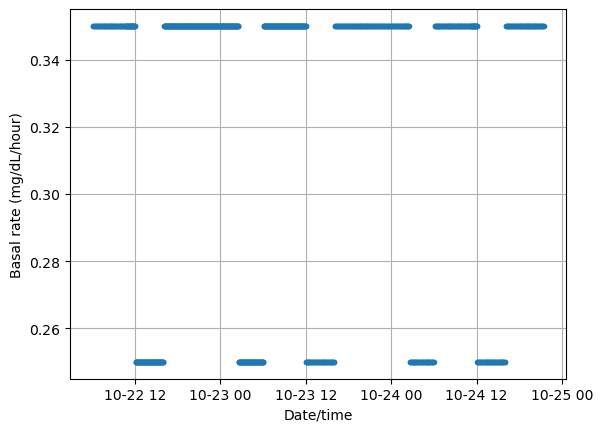

In [7]:
in_times = df_entries["time"].iloc[53700:]

basal = oop.get_setting_at_times(in_times, col_profile, req_setting = "basal", req_profile = "Default")

plt.plot(in_times, basal,'.')
plt.xlabel('Date/time')
plt.ylabel('Basal rate (mg/dL/hour)')
plt.grid()

*(As an aside can I just ask: why on earth did the date/time axis come out alright this time?? I literally copy-pasted)*

Anyway it's all great and grand... but what time zone is everyting in? Let's take a peek into the profile collection.

In [15]:
col_profile.find_one()

{'_id': ObjectId('640f352d6e07c40208d8e59e'),
 'defaultProfile': 'Alma',
 'store': {'Alma': {'dia': 3,
   'carbratio': [{'time': '00:00', 'value': 25, 'timeAsSeconds': 0},
    {'time': '05:30', 'value': 15},
    {'time': '10:30', 'value': 18},
    {'time': '21:00', 'value': 25}],
   'carbs_hr': 20,
   'delay': 20,
   'sens': [{'time': '00:00', 'value': 150, 'timeAsSeconds': 0}],
   'timezone': 'US/Eastern',
   'basal': [{'time': '00:00', 'value': 0.2, 'timeAsSeconds': 0}],
   'target_low': [{'time': '00:00', 'value': 70, 'timeAsSeconds': 0}],
   'target_high': [{'time': '00:00', 'value': 180, 'timeAsSeconds': 0}],
   'units': 'mg/dl'}},
 'startDate': '2022-12-02T00:00:00.000Z',
 'mills': 0,
 'units': 'mg/dl',
 'created_at': '2023-03-13T14:37:33.558Z'}

In the document above, there is a 'timezone' parameter, and it shows 'US/Eastern'. This is important here because the various settings only refer to time in hours and minutes, so you really need to know get the time zone right to have the treatments working appropriately. 

This next little function is just a helper function I made to look at the most recent document in a Mongodb collection. 

In [47]:
def get_last_doc(col):
    """
    Get the last/most recent document in the collection
    """
    return [prof for prof in col.find().skip(col.estimated_document_count() - 1)][0]


Now if I use that function to look at the last document in the col_profile collection, I can see that the timezone here is 'ETC/GMT+4'.

In [48]:
get_last_doc(col_profile)

{'_id': ObjectId('6538ef8df4d651012f4dcdd9'),
 'startDate': '2023-10-25T10:35:56Z',
 'loopSettings': {'dosingStrategy': 'tempBasalOnly',
  'dosingEnabled': True,
  'maximumBolus': 8,
  'minimumBGGuard': 75,
  'preMealTargetRange': [75, 100],
  'overridePresets': [{'name': 'Exercise',
    'targetRange': [130, 150],
    'insulinNeedsScaleFactor': 0.76,
    'symbol': '🏃\u200d♀️',
    'duration': 3600}],
  'deviceToken': '9192bb4f922d8959a71b446a923e879b5d1a67c957d0f75b9bafed000102cb2a',
  'maximumBasalRatePerHour': 1.25,
  'bundleIdentifier': 'com.3Q2XX7Y7LW.loopkit.Loop'},
 'store': {'Default': {'dia': 6,
   'carbs_hr': '0',
   'timezone': 'ETC/GMT+4',
   'target_high': [{'time': '00:00', 'value': 115, 'timeAsSeconds': 0}],
   'carbratio': [{'time': '00:00', 'timeAsSeconds': 0, 'value': 15},
    {'timeAsSeconds': 19800, 'value': 11, 'time': '05:30'},
    {'value': 12, 'time': '11:00', 'timeAsSeconds': 39600},
    {'timeAsSeconds': 57600, 'time': '16:00', 'value': 12},
    {'value': 15, '

Since the time zone could change at any time (if we travel), then we sort of need to monitor it and use that variable all the time. I think that any time we're looking at the time associated with a CGM value for example, we need to adjust based on the time zone. Above, I had just shifted the entire CGM time series into 'US/Eastern', but that's not really the right approach since it could change.

In [49]:
get_last_doc(col_entries)

{'_id': ObjectId('65390b676e601e65dbd23cb5'),
 'sgv': 309,
 'date': 1698237279000.0,
 'dateString': '2023-10-25T12:34:39.000Z',
 'trend': 4,
 'direction': 'Flat',
 'device': 'share2',
 'type': 'sgv',
 'utcOffset': 0,
 'sysTime': '2023-10-25T12:34:39.000Z'}

I just changed a few things at the bottom of the function that was created yesterday, relating to time zones and calculating seconds elapsed in the day. This is now updated in the module but also copied here just to show what was done:

In [ ]:
def get_setting_at_times(in_times, col_prof, req_setting="carbratio", req_profile="Default"):
    """
    A function that returns the requested profile setting from a profile collection at requested times

    Args:
        in_time (array-like): An array of input / requested times in pandas datetime format
        col_prof (mongodb collection): profile collection that includes the carb ratios
        req_setting (str): requested profile setting. Can be "carbratio", "sens", or "basal"
        req_profile (str): requested profile name. Default is "Default".

    Returns: (list) requested setting at the requested date/times

    """
    # ##### Prep time variables #####

    # Convert in_times array to series (if it isn't already)
    in_times = pd.Series(in_times)

    # Convert requested input times to unix
    in_times_unix = in_times.view('int64')

    # Compute seconds elapsed in current day (to get at the current carb ratio)
    seconds_in_day = in_times.dt.hour * 3600 + in_times.dt.minute * 60 + in_times.dt.second

    # ##### Prep profile documents #####

    # Dump every profile document into a list
    prof_docs_all = [prof for prof in col_prof.find({})]

    # Get all the time stamps and convert to unix time (nanoseconds)
    prof_time_unix = [int(prof["mills"]) * 1e6 for prof in prof_docs_all]

    # Get all the "store" items in each document
    all_store = [doc["store"] for doc in prof_docs_all]

    # Pull out all the keys for each "store"
    store_keys = [x.keys() for x in all_store]

    # Extract the "store" info for each document, for any available profiles
    all_store_vals = [[doc[key] for key in store_keys[doc_num]] for doc_num, doc in enumerate(all_store)]

    # Extract the profile names for each document
    all_store_profiles = [[key for key in store_keys[doc_num]] for doc_num, doc in enumerate(all_store)]

    # ##### Next, figure out which profile is appropriate for each requested time #####

    # Get the indices of the most "recent" documents from the collection. Only keep the ones for the requested profile.
    doc_idx = [(len([in_time - t for t_idx, t in enumerate(prof_time_unix) if
                     (in_time - t >= 0) & (req_profile in all_store_profiles[t_idx])]) - 1) for in_time in
               in_times_unix]

    # Profile info for each requested time
    requested_prof_info = [[all_store[this_doc][prof] for prof in all_store_profiles[this_doc]] for this_doc in doc_idx]

    val_req = []
    for idx, prof_info in enumerate(requested_prof_info):
        if req_setting in prof_info[0].keys():
            carb_ratio = prof_info[0][req_setting]
        else:
            raise Exception(
                "The requested setting, " + req_setting + ", is not one of: " + ', '.join(list(prof_info[0].keys())))

        # Ensure that the input time zone (CGM) matches the profile/treatment time zone
        this_req_time_in = in_times.iloc[idx].tz_convert(prof_info[0]['timezone'])
        this_req_time = this_req_time_in.hour * 3600 + this_req_time_in.minute * 60 + this_req_time_in.second

        # Convert treatment time to seconds in day using hours and minutes
        times = [int(cr["time"].split(':')[0]) * 3600 + int(cr["time"].split(':')[1]) * 60 for cr in carb_ratio]
        crs = [cr["value"] for cr in carb_ratio]

        t_diff = [this_req_time - t for t in times]

        val_req.append([crs[idx] for idx, x in enumerate(t_diff) if x > 0][-1])

    return val_req